# Stock Price Prediction Model for a Particular Stock

## Imports and Installation

Make sure you have the required libraries installed. Using the yahoo finance library also requires an internet connection.

In [2]:
# !pip install torch
# !pip install torch-summary
# !pip install yfinance
# !pip install matplotlib
# !pip install scikit-learn

In [1]:
# import required libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import torch.nn as nn
import torch.functional as F

from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

## Initializing stock

In [4]:
# Initialize the stock name and the ticker of that stock for which you want to do this model for. In this example, we're using Amazon (AMZN)
TICKER = "AMZN"
COMPANY_NAME = "Amazon"

# We'll also initialize when we want to start taking data from. It's best to get a few years, so I'll use 2017 in this example, making
# our data go from 2017 to 2023. The date must be in this string format.
START = "2017-01-01"

## Initializing and visualizing our data

In [6]:
# create a ticker object for your wanted stock (AMZN in this example)
ticker = yf.Ticker(TICKER)

# set end=None to ensure the data goes up until the present
df = ticker.history(start=START, end=None)

# show the first 5 rows in our data
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-03 00:00:00-05:00,37.896000,37.938000,37.384998,37.683498,70422000,0.0,0.0
2017-01-04 00:00:00-05:00,37.919498,37.984001,37.709999,37.859001,50210000,0.0,0.0
2017-01-05 00:00:00-05:00,38.077499,39.119999,38.013000,39.022499,116602000,0.0,0.0
2017-01-06 00:00:00-05:00,39.118000,39.972000,38.924000,39.799500,119724000,0.0,0.0
2017-01-09 00:00:00-05:00,39.900002,40.088501,39.588501,39.846001,68922000,0.0,0.0


In [7]:
# Move column 'Close' to the first position
col_close = df.pop('Close')
df.insert(0, 'Close', col_close)

# show the first 5 available dates and their data (oldest dates)
df.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-03 00:00:00-05:00,37.683498,37.896000,37.938000,37.384998,70422000,0.0,0.0
2017-01-04 00:00:00-05:00,37.859001,37.919498,37.984001,37.709999,50210000,0.0,0.0
2017-01-05 00:00:00-05:00,39.022499,38.077499,39.119999,38.013000,116602000,0.0,0.0
2017-01-06 00:00:00-05:00,39.799500,39.118000,39.972000,38.924000,119724000,0.0,0.0
2017-01-09 00:00:00-05:00,39.846001,39.900002,40.088501,39.588501,68922000,0.0,0.0


In [8]:
# show the last 5 available dates and their data (latest dates)
df.tail()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-25 00:00:00-04:00,129.130005,129.309998,129.580002,128.529999,39236700,0.0,0.0
2023-07-26 00:00:00-04:00,128.149994,126.510002,129.080002,126.110001,53910100,0.0,0.0
2023-07-27 00:00:00-04:00,128.250000,131.000000,132.630005,127.790001,52610700,0.0,0.0
2023-07-28 00:00:00-04:00,132.210007,129.690002,133.009995,129.330002,46234700,0.0,0.0
2023-07-31 00:00:00-04:00,133.679993,133.199997,133.869995,132.380005,41821800,0.0,0.0


In [9]:
# tells us what our data looks like as a whole. 1652 rows (days) of data, and 7 columns
df.shape

(1654, 7)

In [10]:
# Contains general information about our data, like the time frame and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1654 entries, 2017-01-03 00:00:00-05:00 to 2023-07-31 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1654 non-null   float64
 1   Open          1654 non-null   float64
 2   High          1654 non-null   float64
 3   Low           1654 non-null   float64
 4   Volume        1654 non-null   int64  
 5   Dividends     1654 non-null   float64
 6   Stock Splits  1654 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 103.4 KB


In [11]:
# Gives us statistical information about our data, such as mean and standard deviation for each of our 7 measures
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1654.0,1.080296e+02,4.039104e+01,3.768350e+01,8.206012e+01,9.714900e+01,1.511370e+02,1.865705e+02
Open,1654.0,1.080748e+02,4.045462e+01,3.789600e+01,8.222212e+01,9.696275e+01,1.515430e+02,1.872000e+02
High,1654.0,1.093557e+02,4.096479e+01,3.793800e+01,8.349625e+01,9.794500e+01,1.539129e+02,1.886540e+02
Low,1654.0,1.066708e+02,3.988918e+01,3.738500e+01,8.108588e+01,9.567500e+01,1.490026e+02,1.848395e+02
Volume,1654.0,8.211841e+07,3.925342e+07,1.762600e+07,5.622452e+07,7.030600e+07,9.566198e+07,3.313000e+08
Dividends,1654.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Stock Splits,1654.0,1.209190e-02,4.917702e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01


In [12]:
# Showing us the number of null/empty values in any columns in any of our rows. There is none which is good.
df.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


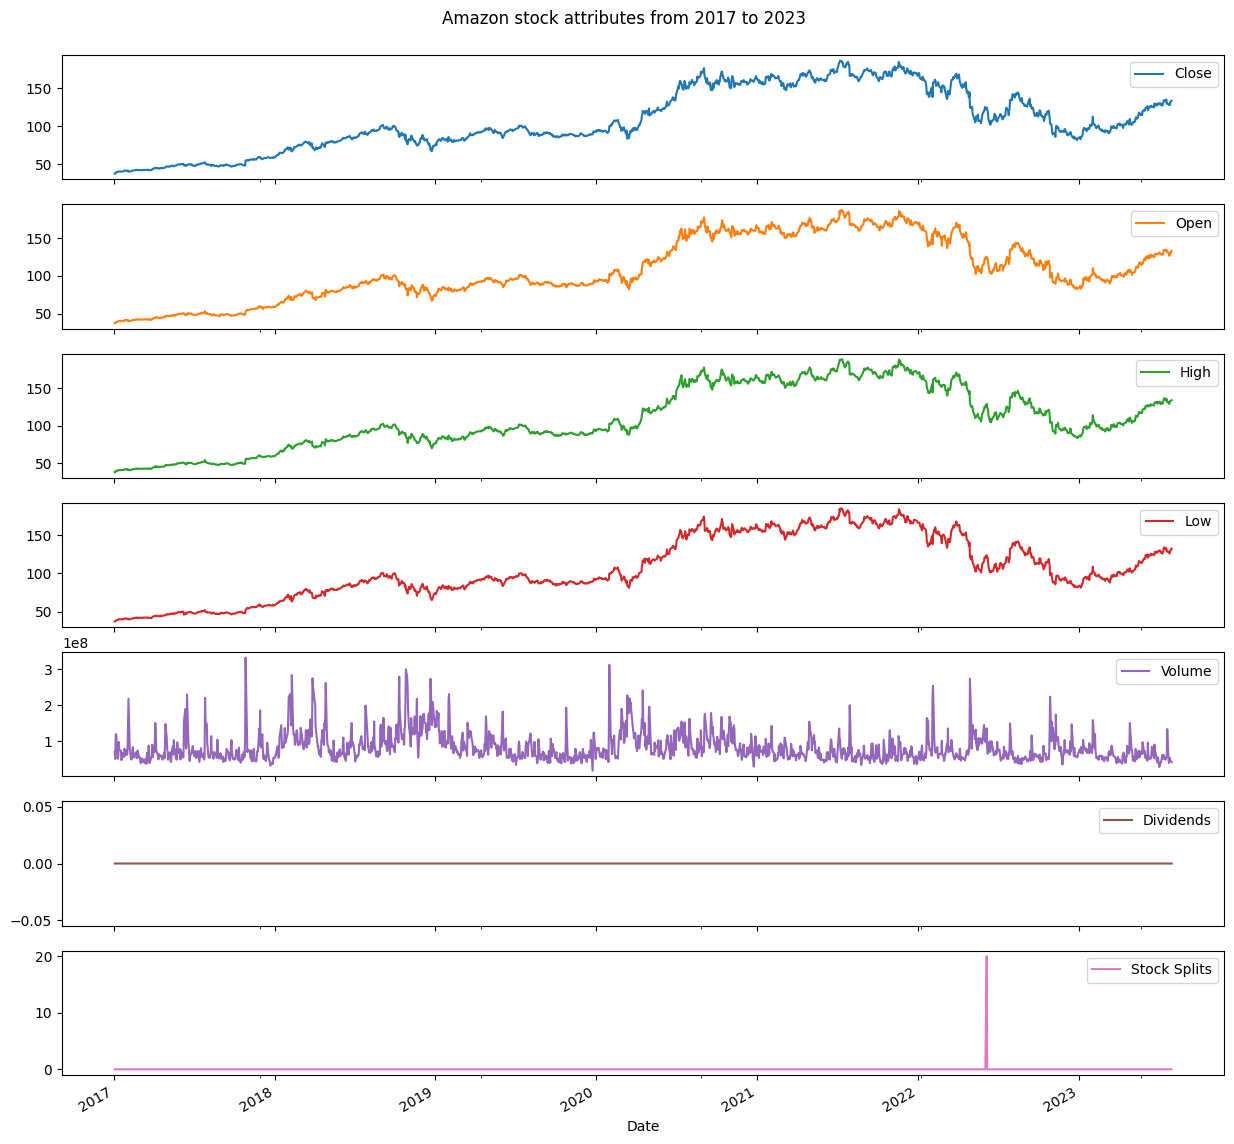

In [13]:
# Here, we are creating plots for each of the stock's measures over time
df.plot(subplots=True, figsize=(15, 15))
plt.suptitle(f'{COMPANY_NAME} stock attributes from {START[:4]} to 2023', y=0.91)
plt.show()

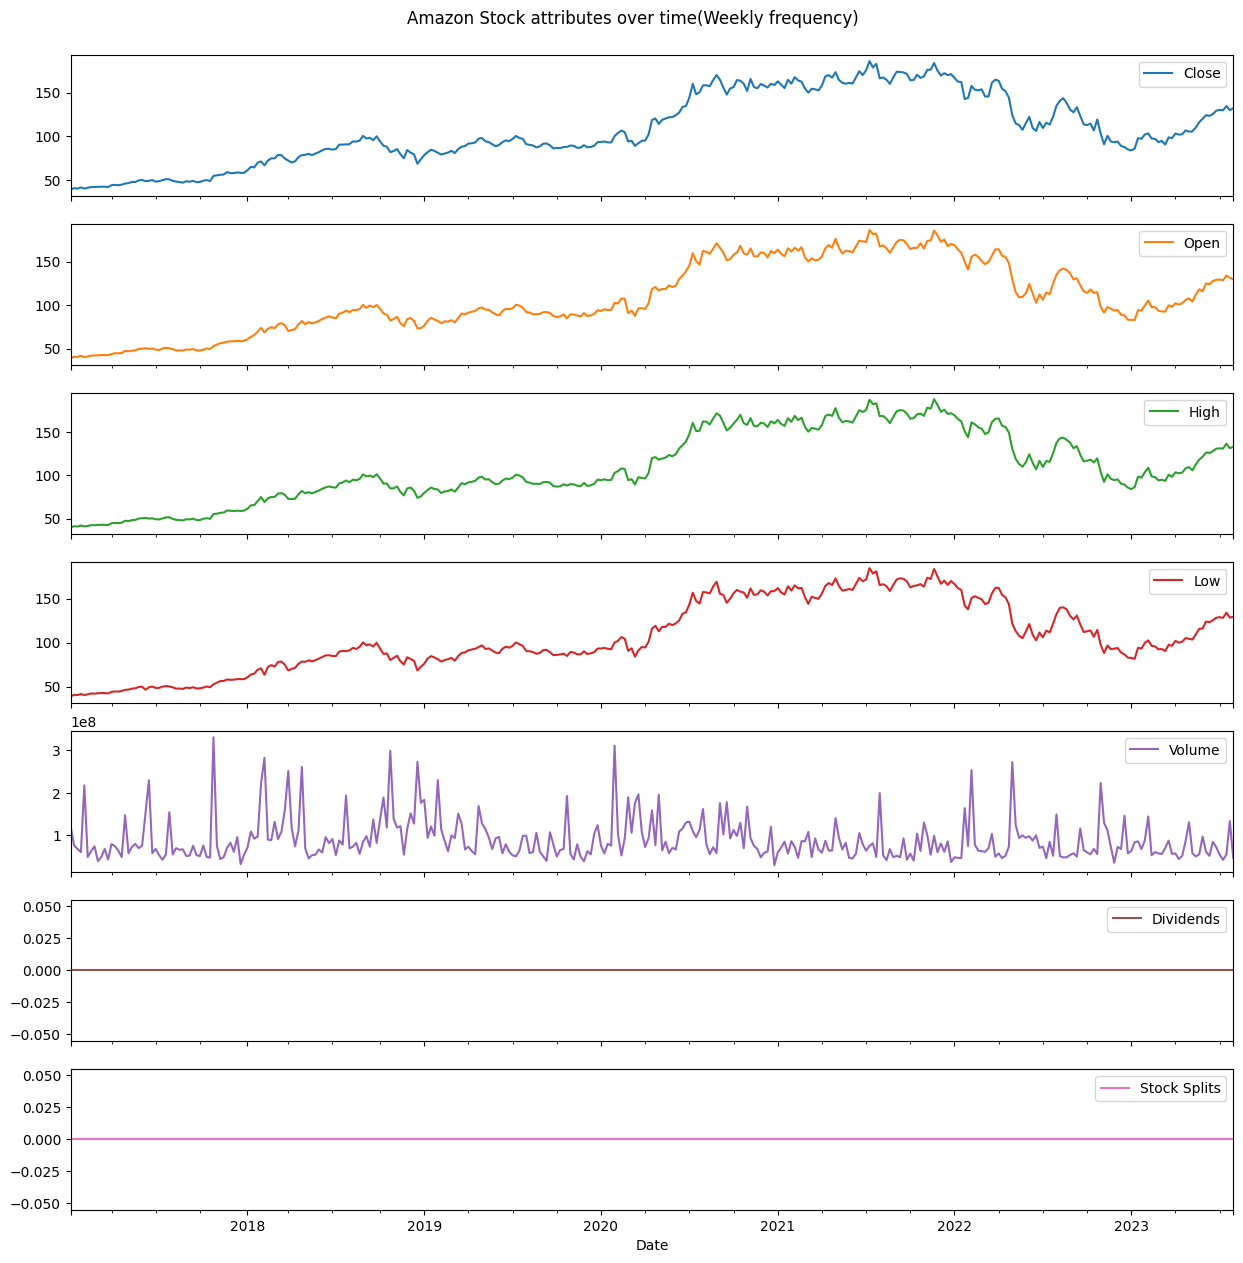

In [14]:
# Here, we are creating plots for each of the stock's measures over time but on a weekly frequency
df.asfreq('W', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle(f'{COMPANY_NAME} Stock attributes over time(Weekly frequency)', y=0.91)
plt.show()

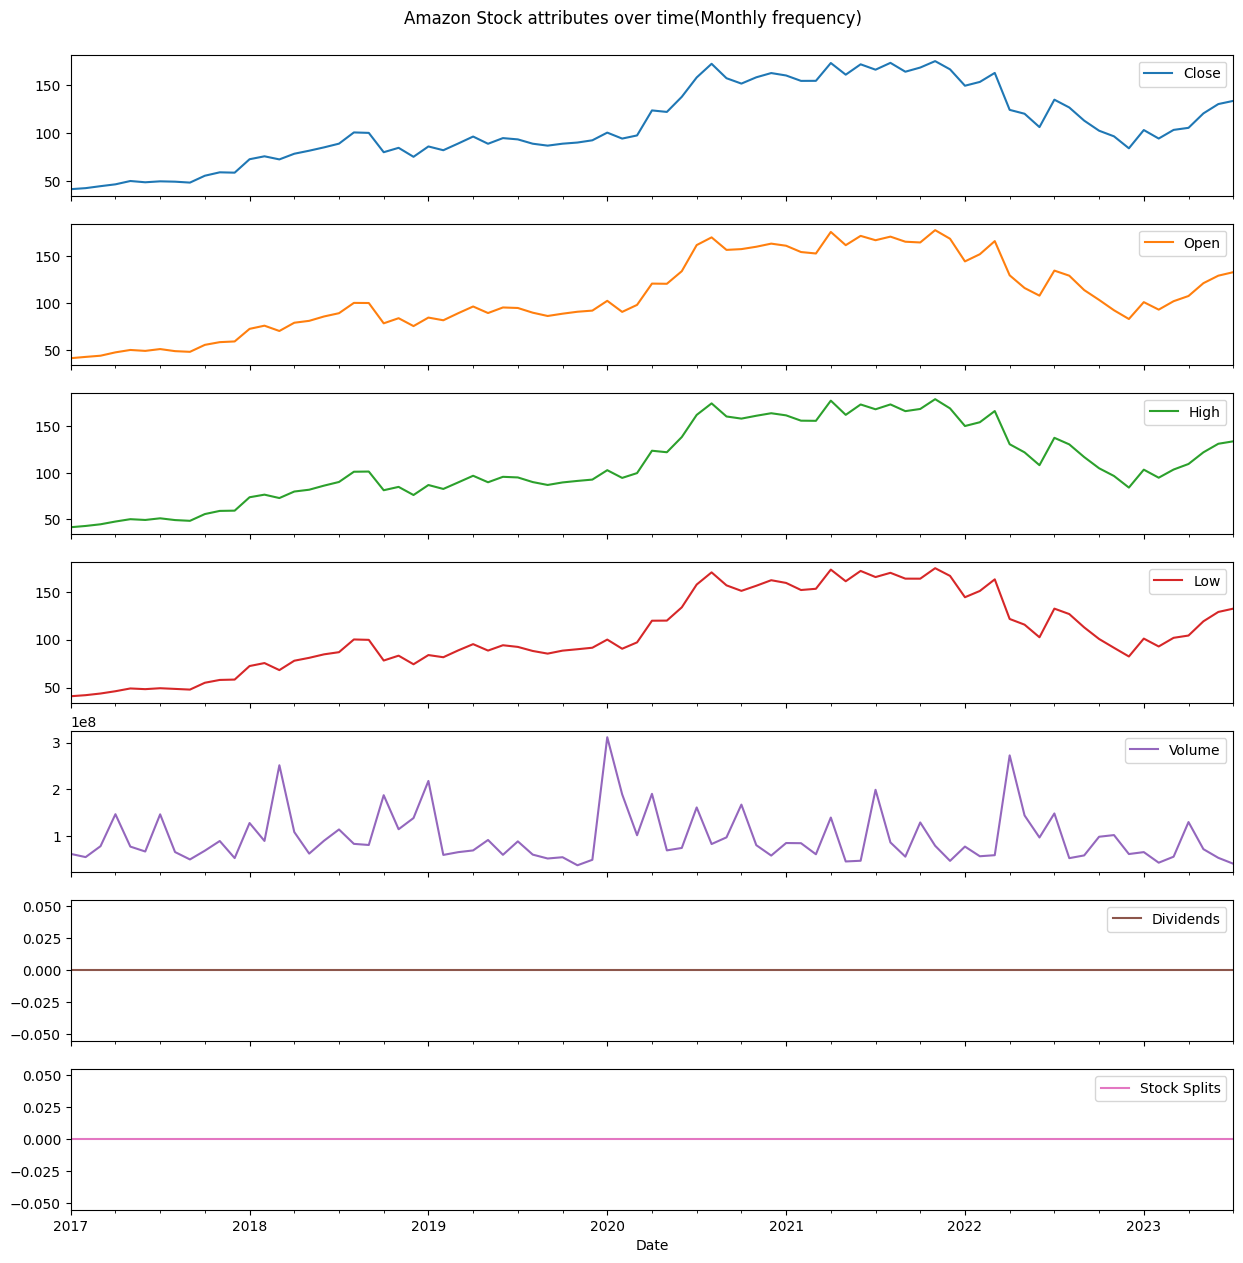

In [15]:
# Here, we are creating plots for each of the stock's measures over time on a monthly frequency
df.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle(f'{COMPANY_NAME} Stock attributes over time(Monthly frequency)', y=0.91)
plt.show()

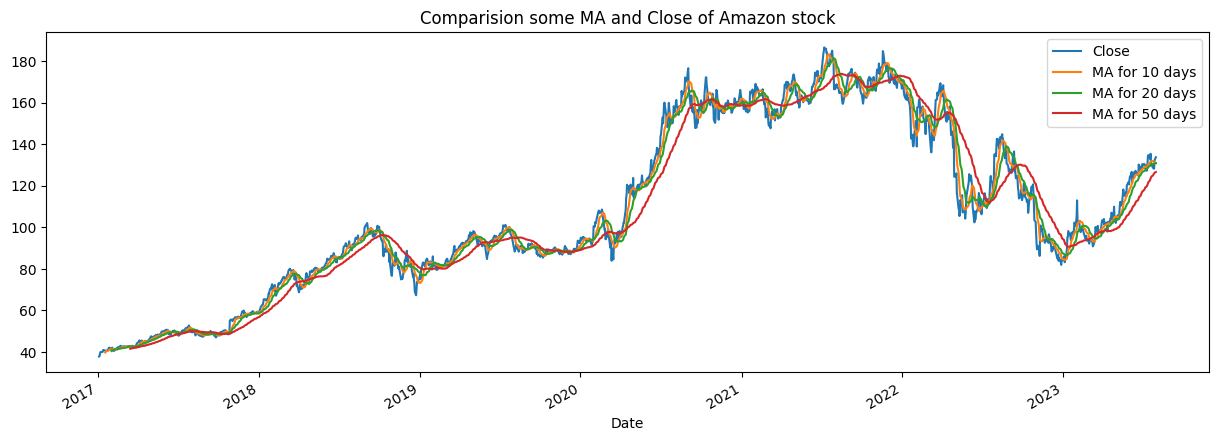

In [16]:
# computing moving average (ma) for the stock
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    df[col_name] = df['Close'].rolling(ma).mean()

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title(f'Comparision some MA and Close of {COMPANY_NAME} stock')
plt.show()

As can be seen, using the 10 and 20 day moving average result in capturing most of the data.

## Data preparation

### Normalizing the data

* `MinMaxScaler` scales tha data to be between 0 and 1 using the mininum as 0 and maximum as 1
* we'll apply this scaling to the `Open`, `High`, `Low`, and `Close` features

In [17]:
df2 = df.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0,15)).fit(df2.Low.values.reshape(-1,1))
df2['Open'] = scaler.transform(df2.Open.values.reshape(-1,1))
df2['High'] = scaler.transform(df2.High.values.reshape(-1,1))
df2['Low'] = scaler.transform(df2.Low.values.reshape(-1,1))
df2['Close'] = scaler.transform(df2.Close.values.reshape(-1,1))
data = df2[['Open','High','Low', 'Close']].values
data.shape

(1654, 4)

Because this is a problem of predicting stock prices, we need to make it a time series problem. The way we'll do that in this case is by using the prices from the previous 10 days to predict what the price will be on the next day. In `sequences`, we're turning the data into 10 day sequences as opposed to originally where the data was on a day by day basis

In [18]:
seq_len=11
sequences=[]
for index in range(len(data) - seq_len + 1):
    sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)

Here, we're using the `sequences` data from above to create our train, test, and validation data

In [21]:
valid_set_size_percentage = 10
test_set_size_percentage = 10

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]

x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]

x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

Here, we're turning the data from above into a format that can be used by PyTorch and then turning it into a Tensor Dataset and finally a DataLoader, allowing us to iterate over the data in batches

In [22]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Here we define the model architecture. Since this is a time series problem, using LSTM allows us to capture the necessary sequential data. A linear layer then takes the hidden state and turns it into a tensor that contains the predicted values for our 4 features.

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = NeuralNetwork(4)

#push to cuda if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

We'll also define our optimizer and our loss function/criterion. We'll be using Adam and Mean Squared Error, respectively.

In [24]:
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

Here, we are defining the training steps for the model

In [27]:
def train(dataloader):
    epoch_loss = 0
    model.train() # put model in training mode

    for batch in dataloader:
        optimizer.zero_grad() # zero the optimizer
        x,y= batch
        pred = model(x) # forward pass
        loss = mse(pred[0],y) # calculate the loss
        loss.backward() # loss backwards (back propagation)
        optimizer.step() # optimizer step
        epoch_loss += loss.item() # accumulate loss

    return epoch_loss

Here, we are defining the evaluation steps for the model

In [28]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval() # put the model in evaluation mode

    with torch.inference_mode(): # enable the inference mode context manager for PyTorch
      for batch in dataloader:
          x,y= batch
          pred = model(x) # forward pass
          loss = mse(pred[0],y) # calculate the loss
          epoch_loss += loss.item() # accumulate the loss

    return epoch_loss / len(dataloader)

Here, we can define the number of epochs to train on. I'll start with 50, but you can change this as you see fit. 50 should not take long to run.
We will also have an if statement making sure we're saving our best model based on the loss on the validation dataset

In [29]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

    # print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Train Loss: 1969.39654 | 	Val Loss: 23.37199

	Train Loss: 1060.32107 | 	Val Loss: 9.65709

	Train Loss: 628.72301 | 	Val Loss: 3.93313

	Train Loss: 404.41853 | 	Val Loss: 2.69972

	Train Loss: 277.50218 | 	Val Loss: 3.06857

	Train Loss: 233.70343 | 	Val Loss: 3.62364

	Train Loss: 200.78998 | 	Val Loss: 2.52272

	Train Loss: 91.38956 | 	Val Loss: 1.31362

	Train Loss: 55.34728 | 	Val Loss: 0.34264

	Train Loss: 29.83774 | 	Val Loss: 0.66394

	Train Loss: 20.16051 | 	Val Loss: 0.40619

	Train Loss: 15.29013 | 	Val Loss: 0.55871

	Train Loss: 13.16852 | 	Val Loss: 0.63547

	Train Loss: 10.50806 | 	Val Loss: 0.54169

	Train Loss: 10.28269 | 	Val Loss: 0.93929

	Train Loss: 9.45588 | 	Val Loss: 0.40768

	Train Loss: 8.87555 | 	Val Loss: 1.47363

	Train Loss: 12.55012 | 	Val Loss: 0.70687

	Train Loss: 9.41726 | 	Val Loss: 0.39937

	Train Loss: 11.02507 | 	Val Loss: 2.35834

	Train Loss: 13.17170 | 	Val Loss: 0.20478

	Train Loss: 8.30662 | 	Val Loss: 0.32029

	Train Loss: 6.10268 | 	Va

Now that that finished, we are ready to start predicting with the model

In [30]:
# Here, we are loading our best model from above
model=torch.load('saved_weights.pt')

We will begin by making predictions on the test set

In [33]:
x_test= torch.tensor(x_test).float()

with torch.inference_mode():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

<ipython-input-33-6e81c0dfdd45>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test= torch.tensor(x_test).float()


Here, we are comparing our predictions to what the actual prices were for each day in our data.

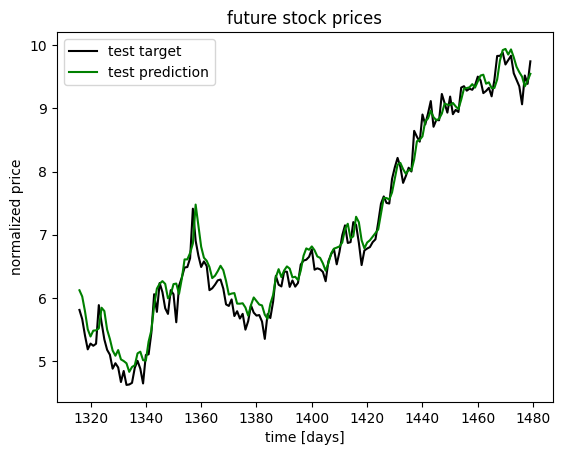

In [34]:
idx=0
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,idx], color='black', label='test target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,idx], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

Now, let's do the same but for the next 10 days for which of course we have no ground truth data

In [36]:
# Get the last sequence of historical data as features for predicting the next 10 days
last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions for the next 10 days
PRED_DAYS = 10
with torch.inference_mode():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PRED_DAYS, 4).numpy()

# inverse transform the predicted values
pred_days = scaler.inverse_transform(pred_days) # scale values back to original values (since we had originally normalized them)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['Open', 'High', 'Low', 'Close']
)

df_pred

,Open,High,Low,Close
0,133.196548,133.887283,129.697052,132.473083
1,133.191772,133.718262,129.525284,132.379654
2,133.105225,133.556381,129.380722,132.250992
3,133.050995,133.463348,129.306091,132.173904
4,133.027939,133.415054,129.272903,132.134827
5,133.051987,133.410721,129.281357,132.136429
6,133.107758,133.440689,129.322784,132.169693
7,133.164978,133.484344,129.373978,132.215088
8,133.198807,133.521240,129.410507,132.250610
9,133.225494,133.551880,129.439926,132.280731
